In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d

from dotenv import load_dotenv, find_dotenv
from pathlib import Path

from src.data.rgbd import load_rgbd
from src.data.pcd import load_pcd
from src.features.cropping import mask_selection_volume, box_mask_from_rgbd

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()
project_dir = Path(dotenv_path).parent

# load up the entries as environment variables
load_dotenv(dotenv_path)

o3d.visualization.webrtc_server.enable_webrtc()

[Open3D INFO] WebRTC GUI backend enabled.


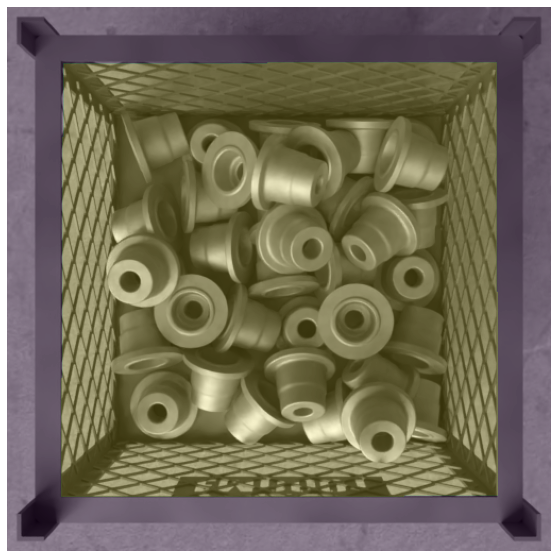

In [3]:
raw_data_dir = project_dir/'data/raw/render_results_imov_cam_mist_simple'

img_fpath = np.random.choice(list(raw_data_dir.glob('*/*.exr')))

rgbd = load_rgbd(img_fpath)

box_mask = box_mask_from_rgbd(rgbd)

plt.imshow(rgbd.color, cmap='gray')
plt.imshow(box_mask, alpha=0.2)
plt.gcf().set_size_inches(10,10)
plt.gca().set_axis_off()
plt.show()

In [4]:
vol = mask_selection_volume(rgbd, box_mask)

pcd = load_pcd(rgbd)

box = vol.crop_point_cloud(pcd)

box

PointCloud with 85861 points.

In [14]:
box_voxel = o3d.geometry.VoxelGrid.create_from_point_cloud(box, 0.01)

o3d.visualization.draw([box_voxel])

In [46]:
box_voxel.get_min_bound()

array([-0.27375172, -0.27261637,  0.12334525])

In [84]:
# get grid shape and position
grid_pos = box_voxel.get_min_bound()
grid_pos[-1] = 0.0  # floor

grid_shape = (box_voxel.get_max_bound() - grid_pos) / box_voxel.voxel_size
grid_shape = (grid_shape + 0.5).astype(int)

grid_pos, grid_shape

(array([-0.27375172, -0.27261637,  0.        ]), array([55, 55, 57]))

In [151]:
indices[0] < grid_shape

array([ True,  True,  True])

In [140]:
def voxel2np(v_grid, pos, shape, is_floating=False):
    grid = np.zeros(shape, dtype=bool)

    offset = (pos - v_grid.get_min_bound()) / v_grid.voxel_size
    offset = (offset + 0.5).astype(int)

    indices = [v.grid_index - offset for v in v_grid.get_voxels()]

    for i in indices:
        if (i > 0).all() and (i < shape).all():
            grid[i[0],i[1],0:i[2]] = True

    if is_floating:
        grid_floating = np.zeros(shape, dtype=bool)
        
        for i in indices:
            if (i > 0).all() and (i < shape).all():
                grid_floating[i[0],i[1],i[2]:-1] = True
        
        grid = grid & grid_floating

    return grid

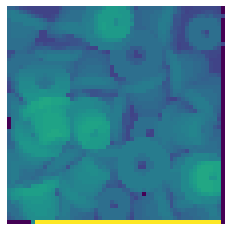

In [141]:
grid = voxel2np(box_voxel, grid_pos, grid_shape)

plt.imshow(grid.sum(axis=-1))
plt.gca().set_axis_off()
plt.show()

In [142]:
part_fpath = project_dir/'data/raw/part.stl'

part_mesh = o3d.io.read_triangle_mesh(str(part_fpath), enable_post_processing=True)

part_mesh.paint_uniform_color([1., 0., 0.,])

part = part_mesh.sample_points_uniformly(number_of_points=10000)

part_points = np.array(part.points) / 1000  # mm to meter conversion
part_points = part_points + np.array([0,0,0.3])
part_points = o3d.utility.Vector3dVector(part_points)
part.points = part_points

part

PointCloud with 10000 points.

In [146]:
part_voxel = o3d.geometry.VoxelGrid.create_from_point_cloud(part, 0.01)

part_voxel

VoxelGrid with 661 voxels.

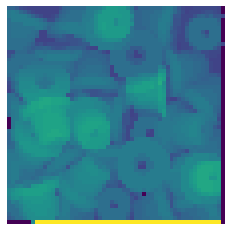

In [147]:
part_grid = voxel2np(part_voxel, grid_pos, grid_shape, is_floating=True)

plt.imshow((part_grid | grid).sum(axis=-1))
plt.gca().set_axis_off()
plt.show()

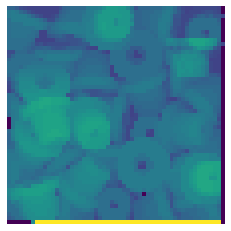

In [148]:
part.translate(np.array([-0.1,0.1,0]))
part.rotate(o3d.geometry.get_rotation_matrix_from_xyz(np.array([0,0,np.pi/2])))

new_part_voxel = o3d.geometry.VoxelGrid.create_from_point_cloud(part, 0.01)

new_part_grid = voxel2np(new_part_voxel, grid_pos, grid_shape, is_floating=True)

plt.imshow((new_part_grid | grid).sum(axis=-1))
plt.gca().set_axis_off()
plt.show()